In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from google.colab import files


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir = '/content/drive/MyDrive/garbage_classification'
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = data_gen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),  # MobileNetV2 expects 224x224 images
    batch_size=32,
    class_mode='sparse',
    subset='training'
)

validation_generator = data_gen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    subset='validation'
)


Found 8731 images belonging to 8 classes.
Found 2180 images belonging to 8 classes.


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')  # Output layer
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


In [ ]:
callbacks = [
    ModelCheckpoint('/content/drive/MyDrive/best_model_mobilenetv2-samp.h5', save_best_only=True, monitor='val_accuracy', verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=11, verbose=1)
]

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
273/273 [==============================] - ETA: 0s - loss: 0.3958 - accuracy: 0.8681
Epoch 1: val_accuracy improved from -inf to 0.88257, saving model to /content/drive/MyDrive/best_model_mobilenetv2-samp.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


273/273 [==============================] - 2688s 10s/step - loss: 0.3958 - accuracy: 0.8681 - val_loss: 0.3337 - val_accuracy: 0.8826
Epoch 2/20
273/273 [==============================] - ETA: 0s - loss: 0.1914 - accuracy: 0.9336
Epoch 2: val_accuracy improved from 0.88257 to 0.90872, saving model to /content/drive/MyDrive/best_model_mobilenetv2-samp.h5
273/273 [==============================] - 522s 2s/step - loss: 0.1914 - accuracy: 0.9336 - val_loss: 0.2650 - val_accuracy: 0.9087
Epoch 3/20
273/273 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.9448
Epoch 3: val_accuracy did not improve from 0.90872
273/273 [==============================] - 564s 2s/step - loss: 0.1509 - accuracy: 0.9448 - val_loss: 0.2643 - val_accuracy: 0.9069
Epoch 4/20
273/273 [==============================] - ETA: 0s - loss: 0.1131 - accuracy: 0.9572
Epoch 4: val_accuracy improved from 0.90872 to 0.91101, saving model to /content/drive/MyDrive/best_model_mobilenetv2-samp.h5
273/273 [==

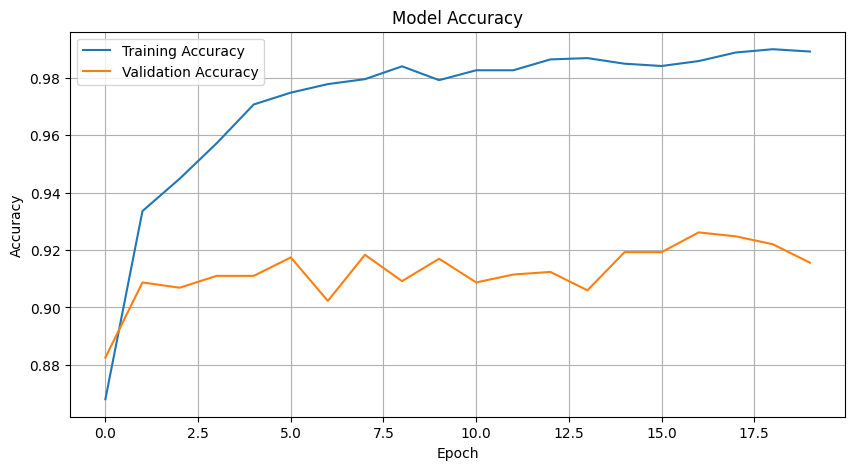

In [ ]:
# Plotting the accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


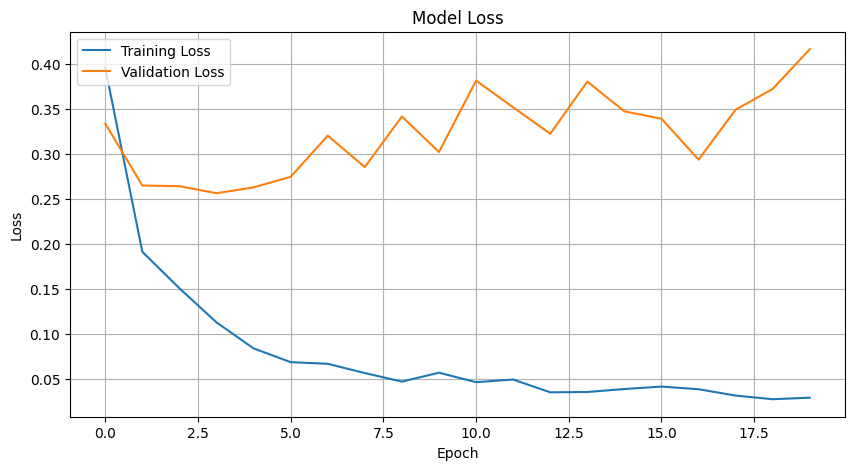

In [ ]:
# Plotting the loss graph
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
!pip install opencv-python-headless  # headless, since we don't have a GUI in Colab

Saving images (4).jpeg to images (4).jpeg
1/1 [==============================] - 1s 1s/step


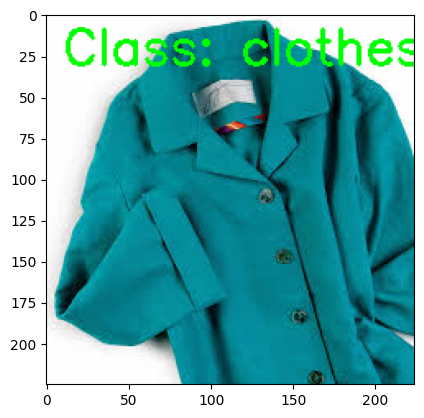

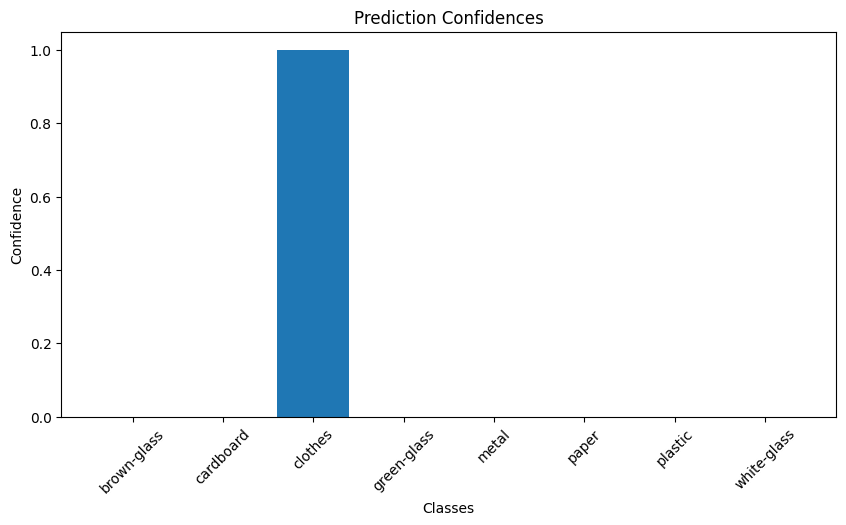

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from google.colab import files

# Define class labels
class_labels = ['brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'white-glass']

# Load the trained model
model = load_model('/content/drive/MyDrive/best_model_mobilenetv2.h5')

# Function to display prediction confidences
def display_prediction_confidences(predictions):
    plt.figure(figsize=(10, 5))
    plt.bar(class_labels, predictions[0])  # Update x-ticks to class labels
    plt.title('Prediction Confidences')
    plt.xlabel('Classes')
    plt.ylabel('Confidence')
    plt.xticks(rotation=45)  # Rotate labels for better visibility
    plt.show()

# Function to upload and predict an image
def upload_and_predict():
    uploaded = files.upload()
    for fn in uploaded.keys():
        path = '/content/' + fn
        img = image.load_img(path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0

        predictions = model.predict(img_array)
        max_confidence = np.max(predictions[0])
        predicted_class_index = np.argmax(predictions[0])
        predicted_class_name = class_labels[predicted_class_index] if max_confidence > 0.7 else 'None'  # Threshold set at 0.7

        img_cv = cv2.imread(path)
        cv2.putText(img_cv, f"Class: {predicted_class_name}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
        plt.show()

        display_prediction_confidences(predictions)

upload_and_predict()


<IPython.core.display.Javascript object>

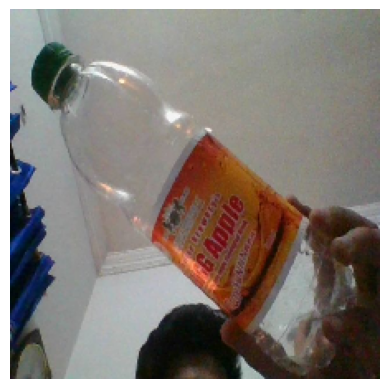

1/1 [==============================] - 1s 888ms/step
The uploaded image is classified as: plastic


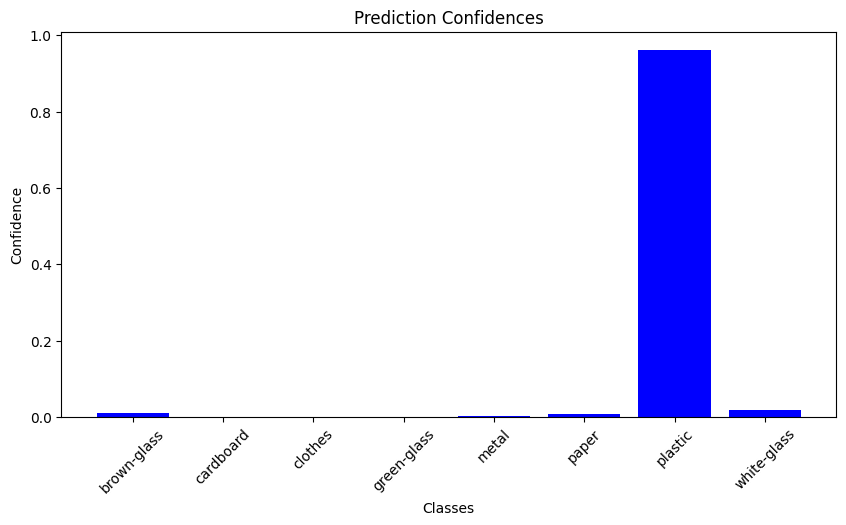

In [4]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Function to capture an image from the webcam
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Function to display prediction confidences
def display_prediction_confidences(predictions, class_labels):
    confidences = predictions[0]
    plt.figure(figsize=(10, 5))
    plt.bar(class_labels, confidences, color='blue')
    plt.title('Prediction Confidences')
    plt.xlabel('Classes')
    plt.ylabel('Confidence')
    plt.xticks(rotation=45)
    plt.show()

# Load the trained model
model = load_model('/content/drive/MyDrive/best_model_mobilenetv2.h5')

# Define class labels
class_labels = ['brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'white-glass']

# Capture an image from the webcam
image_path = take_photo()

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Display the captured image
plt.imshow(img)
plt.axis('off')
plt.show()

# Predict the class of the input image
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
predicted_class_name = class_labels[predicted_class_index]
confidence = predictions[0][predicted_class_index]

# Check if the prediction confidence is above the threshold
if confidence > 0.6:  # Threshold set at 0.6
    print(f"The uploaded image is classified as: {predicted_class_name}")
else:
    print("The uploaded image is classified as: None")

# Display the prediction confidences
display_prediction_confidences(predictions, class_labels)
